In [1]:
import sys
import pandas as pd
import random
import math
#import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
from scipy.stats import poisson
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import special
import operator
from numpy import genfromtxt

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (NVIDIA A100-PCIE-40GB) of compute capability 8.0 with 42.4Gb total memory.



In [3]:
#intialization: theta is based on estimated doublet proportion; 
#               alpha and beta is estimated by assuming a simple gamma distribution and estimated by method of moment
def initialization(theta, data):
  #theta is a numerical value
  #data should be the count matrix in tensor form
  theta = torch.tensor(theta, device = dev)
  mu = torch.mean(data, dim=0)
  var = torch.var(data, dim=0)
  alpha = torch.square(mu)/var.to(dev)
  beta = mu/var.to(dev)

  theta = theta.requires_grad_()
  alpha = alpha.requires_grad_()
  beta = beta.requires_grad_()

  return theta, alpha, beta

#log likelihood
def loglik(N, theta, alpha, beta, decay, data):
  #N is the user estimated maximum number of cells in a droplet
  #theta, alpha, and beta are outputs from initialization function
  #data should be the count matrix in tensor form
  
  poisson = torch.distributions.Poisson(theta)
  for k in range(N):
    gamma = torch.distributions.Gamma(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), beta)
    if k ==0 :
      sum_k = gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp()
    else:
      sum_k = sum_k.clone() + gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp() #sum of likelihood

  l = sum_k.log().sum()
  return l

def MLE(data,N=3, p=0.7,  lr=0.001, tolerance = 15):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization(theta, data)
    alpha0 = 2*torch.mean(alpha).to('cpu').detach().item()
    parameters = [theta, alpha, beta, decay]

    # Defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(parameters, lr=learning_rate) # not working
    optimizer = optim.Adam(parameters, lr=lr)
    #optimizer = optim.Rprop(parameters, lr=learning_rate)
    NLL_0 = -loglik(N, theta, alpha, beta, decay, x)
    l = []
    singlet_rate = []

    for i in range(5000):
        #theta = theta.clone().clamp_(0.001, 1)
        NLL = -loglik(N, theta, alpha, beta, decay, x)
        if i % 200 == 0:
            #print("neg loglik  =", i, NLL.data, theta.data, decay.data)
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1
        #print(theta)
        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.001, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = alpha0)

    

    return theta, alpha, beta, decay, l, singlet_rate

def compound_poisson_gamma_cdf(data, alpha, beta, theta, decay, N=3):
  #calculate estimated distribution for each gene
  #grid = np.expand_dims(np.arange(0, np.max(data), 0.1), axis = 0)
  grid = np.expand_dims(np.arange(0, np.maximum(np.max(data),500), 1), axis = 0)
  grid = np.repeat(grid, data.shape[1], axis = 0)
  grid = grid.T
  
  for k in range(N):
    if k==0:
      cdf = poisson.pmf(k, theta)*(gamma.cdf(grid, alpha*torch.pow(decay, torch.arange(k+1, device = dev)).sum(), loc=0, scale=1/beta).to('cpu').detach().numpy())
    else:
      cdf += poisson.pmf(k, theta)*(gamma.cdf(grid, alpha*torch.pow(decay, torch.arange(k+1, device = dev)).sum(), loc=0, scale=1/beta).to('cpu').detach().numpy())

  return cdf

def empirical_cdf(data):
  grid = np.expand_dims(np.arange(0, np.maximum(np.max(data),100), 0.01), axis = 0)
  grid = np.repeat(grid, data.shape[1], axis = 0)
  grid = grid.T
  grid = np.expand_dims(grid, axis = 1)

  emp_cdf = np.sum(data < grid, 1)/data.shape[0]

  return emp_cdf

def goodness_of_fit(data, alpha, beta, theta, decay, N=3):

  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  data = data - 0.0001
  theta = theta.to('cpu').detach().numpy()

  diff = abs(empirical_cdf(data)-compound_poisson_gamma_cdf(data, alpha, beta, theta, decay, N))
  dn = np.max(diff, axis = 0)


  
  print(dn)
  print("Distribution of Kolmogorov–Smirnov statistics across all genes")
  print("Lower values indicate better fit")




In [4]:
def log_joint_one_k(data, theta, alpha, beta, decay, k0):
  #k0 starts from 0, same interpretation as the k0 in the derivation
  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  theta = theta.to('cpu').detach().numpy()
  decay = decay.to('cpu').detach().numpy()

  alpha = alpha*(1+k0/(1+np.exp(-decay)))
  #alpha = alpha*(np.power(decay, np.arange(k0+1)).sum())

  #log_conditional = np.log(gamma.pdf(data+0.01, alpha, loc=0, scale=1/beta)) 
  log_conditional = np.log(gamma.pdf(data, alpha, loc=0, scale=1/beta)) 
  sum_gene = np.sum(log_conditional, axis = 1)
  log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
  #var_by_cell = np.var(log_conditional, axis = 1)
  var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0(data, theta, alpha, beta, decay, k0, k=3):
  log_joint_k0 = log_joint_one_k(data, theta, alpha, beta, decay, k0)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k(data, theta, alpha, beta, decay, i)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)
  
  #reliability = 1-1/var_by_cell/max(1/var_by_cell)
  #reliability = 1-var_by_cell/max(var_by_cell)

  return prob

def reliability_atac(data, theta, alpha, beta, decay, k=3):
    
    
    prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k)
    prob_doublet = 1-prob_singlet
    pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = small_stable.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.pdf(data,  alpha_k, loc=0, scale=1/beta))

        

    
    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature

    
    
    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def atac_fit_goodness(data, alpha, beta, theta, decay, k=3):
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0] #+ 1e-100 #adjust 1e-100 as needed
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.cdf(grid, alpha_k, loc=0, scale=1/beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    return mean_ks

def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    precision = np.sum(dichotomized[label==1]==1)/np.sum(dichotomized==1)
    prop = np.sum(dichotomized==1)/label.shape[0]
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    print("Predicted doublet proportion:",prop)
    print("Precision:", precision)
    print("f1 score:", f1)
    
    return sensitivity, specificity

## PB-1 ATAC

In [5]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220215_1/
stable = pd.read_csv("./ATAC_stable500_cts.csv")
small_stable = stable.iloc[:, 1:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220215_1


In [6]:
small_stable = torch.tensor(small_stable.values, device = dev) 
small_stable = small_stable.double() 
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [7]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ihome/crc/install/cuda-11.3/pytorch/1.11.0_gpu/python3.8/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /ihome/wchen/hah112/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


In [8]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.2155402136639542

0.697536014150248


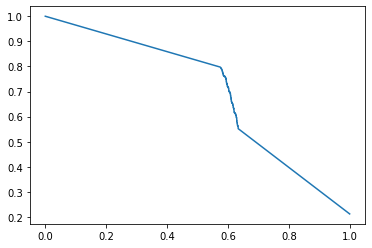

In [9]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [10]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.19598258611471778
Precision: 0.6628994544037412
f1 score: 0.6360067302299496


In [11]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220215_1_atac.csv',index=False)

In [12]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_1_atac.csv',index=False)

## PB-1 RNA+ATAC

In [13]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/doublet_20220215_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/doublet_20220215_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/reliability_20220215_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/reliability_20220215_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7641677975578858


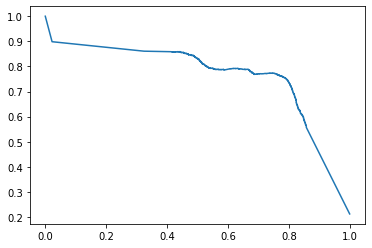

In [14]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [15]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.26212479951118917
Precision: 0.6675407925407926
f1 score: 0.7372485921158488


## PB-2 ATAC

In [16]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220215_2/
stable = pd.read_csv("./ATAC_stable500_cts.csv")
small_stable = stable.iloc[:, 1:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220215_2


In [17]:
small_stable = torch.tensor(small_stable.values, device = dev) 
small_stable = small_stable.double() 
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [18]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [19]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.19666664618746799

0.7200845667472392


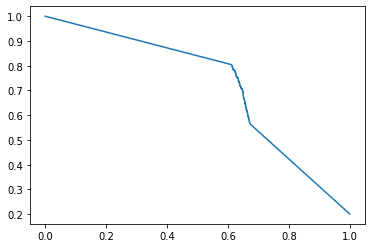

In [20]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [21]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.19294377067254687
Precision: 0.6778571428571428
f1 score: 0.6639846073115269


In [22]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220215_2_atac.csv',index=False)

In [23]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_2_atac.csv',index=False)

## PB-2 RNA+ATAC

In [24]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/doublet_20220215_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/doublet_20220215_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/reliability_20220215_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/reliability_20220215_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.749512552614914


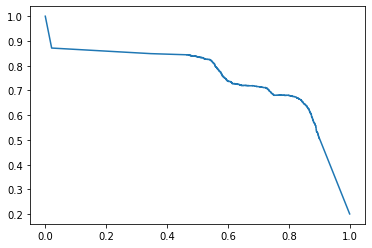

In [25]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [26]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27928610804851156
Precision: 0.6237355045645201
f1 score: 0.7253945480631276


## PB-3 ATAC

In [27]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220218_1/
stable = pd.read_csv("./ATAC_stable500_cts.csv")
small_stable = stable.iloc[:, 1:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220218_1


In [28]:
small_stable = torch.tensor(small_stable.values, device = dev) 
small_stable = small_stable.double() 
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [29]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [30]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1919114811324909

0.7540825078647092


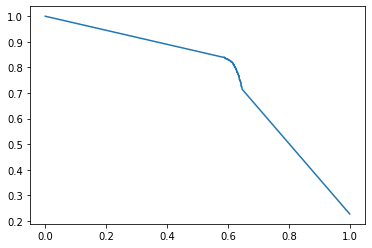

In [31]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [32]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.18007688676063938
Precision: 0.7925093632958802
f1 score: 0.7000827129859388


In [33]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_1_atac.csv',index=False)

In [34]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_1_atac.csv',index=False)

## PB-3 RNA+ATAC

In [35]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/doublet_20220218_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/doublet_20220218_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/reliability_20220218_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/reliability_20220218_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7687817001311928


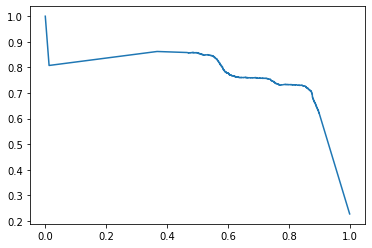

In [36]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [37]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27389222364605115
Precision: 0.7175572519083969
f1 score: 0.7837547068316298


## PB-4 ATAC

In [38]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220218_2/
stable = pd.read_csv("./ATAC_stable500_cts.csv")
small_stable = stable.iloc[:, 1:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220218_2


In [39]:
small_stable = torch.tensor(small_stable.values, device = dev) 
small_stable = small_stable.double() 
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [40]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [41]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1793832880375153

0.7652335540022442


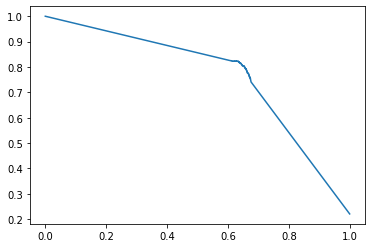

In [42]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [43]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.1799870428175982
Precision: 0.8013743455497382
f1 score: 0.7202941176470588


In [44]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_2_atac.csv',index=False)

In [45]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_2_atac.csv',index=False)

## PB-4 RNA+ATAC

In [46]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/doublet_20220218_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/doublet_20220218_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/reliability_20220218_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/reliability_20220218_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7644769681799455


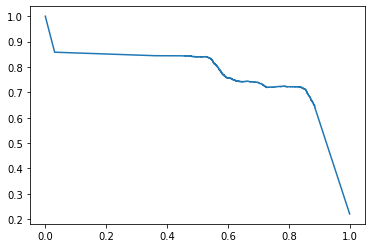

In [47]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [48]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2599092997231875
Precision: 0.7169725810106503
f1 score: 0.7757754076253524


## Ileum-1 ATAC

In [49]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230124_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230124_1


In [50]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [51]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [52]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17635970874445375

0.6272374972168634


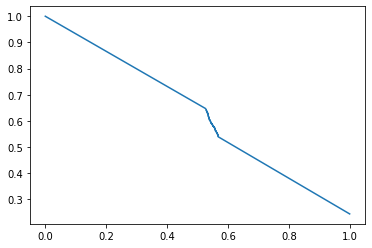

In [53]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [54]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23251794039076004
Precision: 0.5791845010137419
f1 score: 0.5653034300791556


In [55]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_1_atac.csv',index=False)

In [56]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_1_atac.csv',index=False)

## Ileum-1 RNA+ATAC

In [57]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/doublet_20230124_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/doublet_20230124_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/reliability_20230124_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/reliability_20230124_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6788685175855832


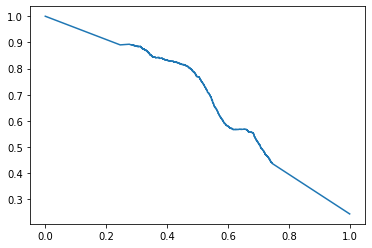

In [58]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [59]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.291708134723168
Precision: 0.5580894235949003
f1 score: 0.6078623117543516


## Ileum-2 ATAC

In [60]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230124_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230124_2


In [61]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [62]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [63]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.19730384096764333

0.6296034491652591


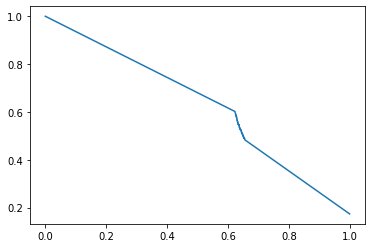

In [64]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [65]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.21179578475851377
Precision: 0.5257592190889371
f1 score: 0.5777711561382598


In [66]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_2_atac.csv',index=False)

In [67]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_2_atac.csv',index=False)

## Ileum-2 RNA+ATAC

In [68]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/doublet_20230124_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/doublet_20230124_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/reliability_20230124_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/reliability_20230124_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6935259204587739


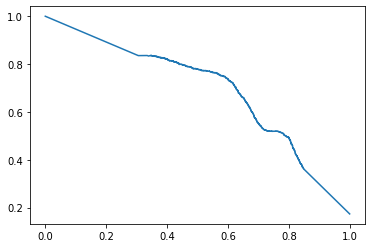

In [69]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [70]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27203813242979386
Precision: 0.5022165927802407
f1 score: 0.6130653266331658


## Ileum-3 ATAC

In [71]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230126_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230126_1


In [72]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [73]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [74]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.2588966205377892

0.44871954431423466


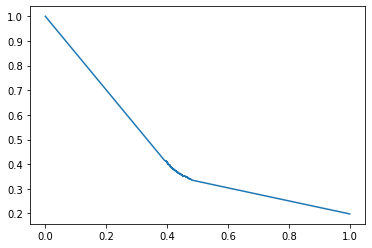

In [75]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [76]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2464034057545508
Precision: 0.35865355972594576
f1 score: 0.3974909210960713


In [77]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_1_atac.csv',index=False)

In [78]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_1_atac.csv',index=False)

## Ileum-3 RNA+ATAC

In [79]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/doublet_20230126_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/doublet_20230126_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/reliability_20230126_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/reliability_20230126_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.49581750667937907


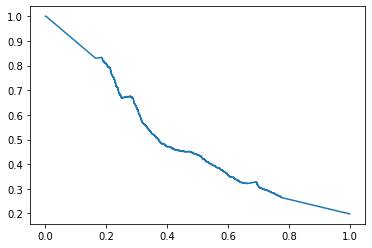

In [80]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [81]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.40443335290663535
Precision: 0.3221415607985481
f1 score: 0.43234685178419197


## Ileum-4 ATAC

In [82]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230126_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230126_2


In [83]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [84]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [85]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.25721424624766037

0.48669468133699856


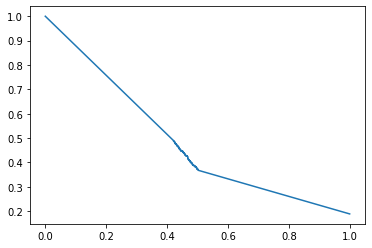

In [86]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [87]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2188976377952756
Precision: 0.407782864617397
f1 score: 0.43815881939564305


In [88]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_2_atac.csv',index=False)

In [89]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_2_atac.csv',index=False)

## Ileum-4 RNA+ATAC

In [90]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/doublet_20230126_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/doublet_20230126_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/reliability_20230126_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/reliability_20230126_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.534691524623933


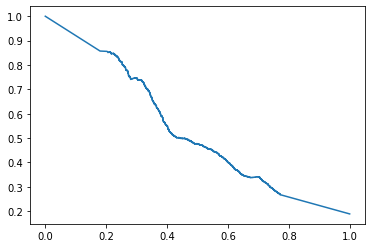

In [91]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [92]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.37201145311381534
Precision: 0.3394265922647681
f1 score: 0.45051717532882135


## Ileum-5 ATAC

In [93]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230203_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230203_1


In [94]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [95]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [96]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.42043289859114946

0.3979198737935631


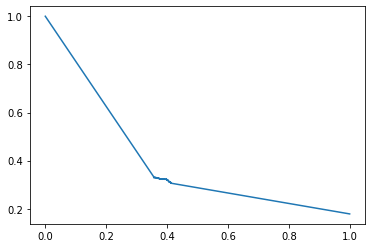

In [97]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [98]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.22467353394435882
Precision: 0.3187725631768953
f1 score: 0.35518905872888173


In [99]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_1_atac.csv',index=False)

In [100]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_1_atac.csv',index=False)

## Ileum-5 RNA+ATAC

In [101]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/doublet_20230203_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/doublet_20230203_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/reliability_20230203_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/reliability_20230203_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.5726489308991498


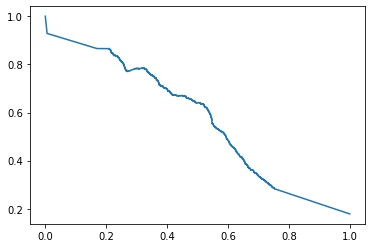

In [102]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [103]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.3052153459323546
Precision: 0.38586234387456814
f1 score: 0.48683989941324396


## Ileum-6 ATAC

In [104]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230203_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230203_2


In [105]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [106]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [107]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.4300081795057461

0.3749461579315303


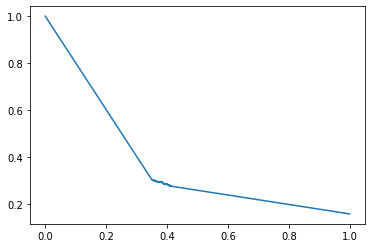

In [108]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [109]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.21985067359194935
Precision: 0.2857142857142857
f1 score: 0.33119383825417203


In [110]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_2_atac.csv',index=False)

In [111]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_2_atac.csv',index=False)

## Ileum-6 RNA+ATAC

In [112]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/doublet_20230203_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/doublet_20230203_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/reliability_20230203_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/reliability_20230203_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.5307951753114026


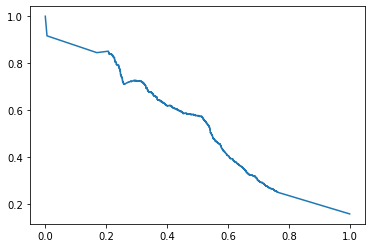

In [113]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [114]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.305713358221068
Precision: 0.3435094239447836
f1 score: 0.4515003489183531


## Ileum-7 ATAC

In [115]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230206_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20230206_2


In [116]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [117]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [118]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.22862192232838222

0.5065516359505737


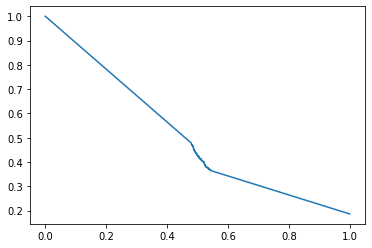

In [119]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [120]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.24139061987536897
Precision: 0.4013586956521739
f1 score: 0.45292854952468564


In [121]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230206_2_atac.csv',index=False)

In [122]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230206_2_atac.csv',index=False)

## Ileum-7 RNA+ATAC

In [123]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/doublet_20230206_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/doublet_20230206_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/reliability_20230206_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/reliability_20230206_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.5444945766496628


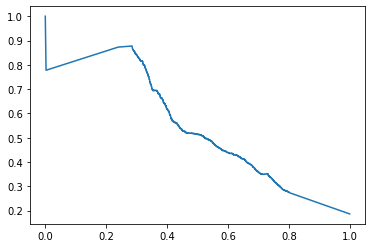

In [124]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [125]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.37769760577238437
Precision: 0.35098992705800625
f1 score: 0.47


## PB-5 ATAC

In [126]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220429_1


In [127]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [128]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [129]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.20579993821368808

0.7148929486191787


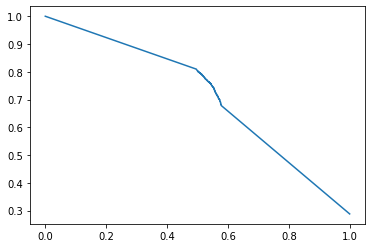

In [130]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [131]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.21385795595149715
Precision: 0.7438093034019903
f1 score: 0.6336750788643533


In [132]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_1_atac.csv',index=False)

In [133]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_1_atac.csv',index=False)

## PB-5 RNA+ATAC

In [134]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/doublet_20220429_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/doublet_20220429_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/reliability_20220429_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/reliability_20220429_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7371940122466009


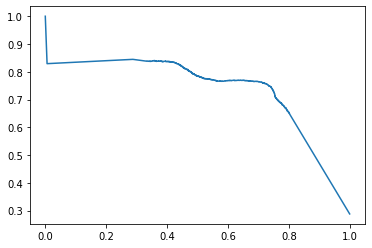

In [135]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [136]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.30744865132392973
Precision: 0.7084674822923374
f1 score: 0.7313668466971333


## PB-6 ATAC

In [137]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220429_2


In [138]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


In [139]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [140]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.180467106415942

0.7744855917276642


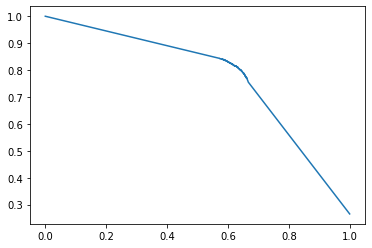

In [141]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [142]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2095457961988618
Precision: 0.8055342044581092
f1 score: 0.7107494065785013


In [143]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_2_atac.csv',index=False)

In [144]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_2_atac.csv',index=False)

## PB-6 RNA+ATAC

In [145]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/doublet_20220429_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/doublet_20220429_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/reliability_20220429_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/reliability_20220429_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7767705019049785


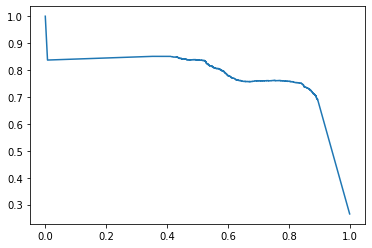

In [146]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [147]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.30543326532803605
Precision: 0.7389699419933204
f1 score: 0.7907457914041193


## PB-7 ATAC

In [148]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_3/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220429_3


In [149]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [150]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [151]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.18647551876242033

0.770727007937053


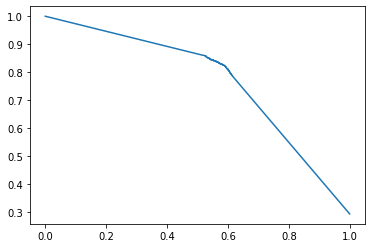

In [152]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [153]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.20802955186157285
Precision: 0.8264018691588785
f1 score: 0.6844040247678019


In [154]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_3_atac.csv',index=False)

In [155]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_3_atac.csv',index=False)

## PB-7 RNA+ATAC

In [156]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/doublet_20220429_3_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/doublet_20220429_3_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/reliability_20220429_3_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/reliability_20220429_3_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7857054634515315


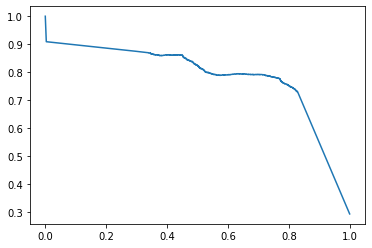

In [157]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [158]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2968795567220764
Precision: 0.7680091683038638
f1 score: 0.7712923380466951


## PB-8 ATAC

In [159]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220524_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features


/ix1/wchen/Haoran/CPDD/ATAC/20220524_1


In [160]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [161]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [162]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1915035986347527

0.7468652814150143


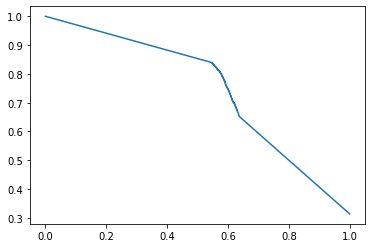

In [163]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [164]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.25255474452554744
Precision: 0.7465405500087581
f1 score: 0.6656774697383835


In [165]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_1_atac.csv',index=False)

In [166]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_1_atac.csv',index=False)

## PB-8 RNA+ATAC

In [167]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/doublet_20220524_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/doublet_20220524_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/reliability_20220524_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/reliability_20220524_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7879698639739225


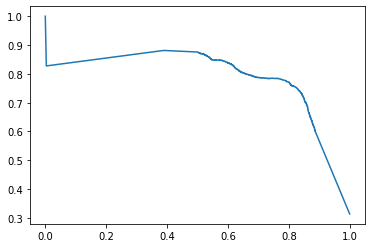

In [168]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [169]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.38084494580844946
Precision: 0.703333720525032
f1 score: 0.7710920089143585


## PB-9 ATAC

In [170]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220524_2/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20220524_2


In [171]:

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [172]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [173]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17857586096514005

0.7363061679025723


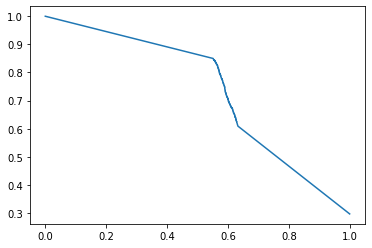

In [174]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [175]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.2493416636546703
Precision: 0.7119486436115138
f1 score: 0.6498440601077402


In [176]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_2_atac.csv',index=False)

In [177]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_2_atac.csv',index=False)

## PB-9 RNA+ATAC

In [178]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/doublet_20220524_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/doublet_20220524_2_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/reliability_20220524_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/reliability_20220524_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8036566183652473


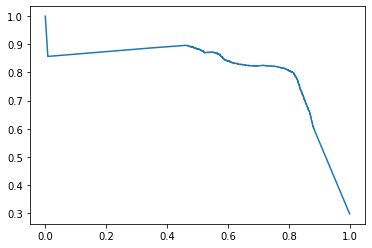

In [179]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [180]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.3574637269582279
Precision: 0.706052289469883
f1 score: 0.7712820512820513


## PB-10 ATAC

In [181]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20210831_1/
stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300] #300 stable features

/ix1/wchen/Haoran/CPDD/ATAC/20210831_1


In [182]:
small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


In [183]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

In [184]:
weight = atac_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1988718424215861

0.7305947006839204


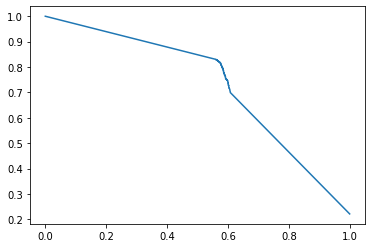

In [185]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [186]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.16791517805693212
Precision: 0.7759094028826355
f1 score: 0.6686381783232292


In [187]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20210831_1_atac.csv',index=False)

In [188]:
reliability_table = reliability_atac(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/(2*weight),
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20210831_1_atac.csv',index=False)

## PB-10 RNA+ATAC

In [189]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/doublet_20210831_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/doublet_20210831_1_rna.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/reliability_20210831_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/reliability_20210831_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.711335617910625


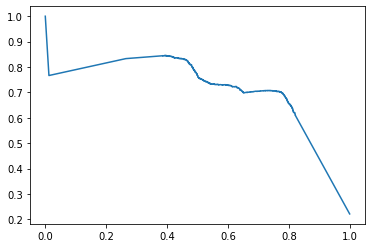

In [190]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [191]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.25279474472744035
Precision: 0.6886254843856849
f1 score: 0.7336085478387566
